In [1]:
!nvidia-smi

Tue Dec 13 17:09:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   26C    P8    11W / 350W |      2MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   

In [2]:
import os, random

# Makes sure the script has acess to one GPU
cuda_device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

import torch
torch.cuda.is_available()

True

In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm  

import torch 
import torch.nn as nn 

import transformers 
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

In [4]:
def set_seed(seed: int, set_random=True):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    if set_random:
        random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [5]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  Set the rabdom seed 
seed = 31
set_seed(seed)

In [6]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer                         # the Tokenizer model
        self.data      = dataframe                         # the full dataset
        self.report    = dataframe.report                  # the text data (i.e., the reports)
        self.targets   = self.data.Report_as_EmotionDistribution # labels' list to classify
        self.max_len   = max_length                        # max length fro truncation

    def __len__(self):
        return len(self.report)

    def __getitem__(self, index):
        report = str(self.report[index])
        report = " ".join(report.split())

        inputs = self.tokenizer.encode_plus(
            report,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }
    
# Creating the dataset and dataloader for the neural network
def get_Fold(k_seed, train_size = 0.8):
    
    train_dataset = final_df_dataset.sample(frac=train_size, random_state=k_seed)
    test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    training_set = CustomDataset(train_dataset, tokenizer, max_length)
    testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

    train_params = {
        'batch_size': train_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    test_params = {
        'batch_size': valid_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader  = DataLoader(testing_set, **test_params)
    
    return training_loader, testing_loader

# Creating the dataset and dataloader for the neural network
def get_collection_Fold(collection):
    
    train_dataset = final_df_dataset[~final_df_dataset["collection"].isin([collection])]
    test_dataset  = final_df_dataset[final_df_dataset["collection"].isin([collection])]

    train_dataset = train_dataset.reset_index(drop=True)
    test_dataset  = test_dataset.reset_index(drop=True)

    training_set = CustomDataset(train_dataset, tokenizer, max_length)
    testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

    train_params = {
        'batch_size': train_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    test_params = {
        'batch_size': valid_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader  = DataLoader(testing_set, **test_params)
    
    return training_loader, testing_loader

# Creating the customized model, by adding a drop out and a dense layer on top of 
# the BERT (or any other) model, to get the final output. 
class BERT_arch(torch.nn.Module):
    def __init__(self, model_name, n_classes, freeze_BERT=False, layer=-1, idx=0, n_feat=1024):
        super(BERT_arch, self).__init__()
        
        self.l1 = transformers.BertModel.from_pretrained(model_name)
        self.l2 = torch.nn.Linear(n_feat, int(n_feat/2))
        self.l3 = torch.nn.Linear(int(n_feat/2), n_classes)
        self.F  = nn.ReLU()
        
        self.layer = layer
        self.idx   = idx  
        
        # Froze the weight of model aside of the classifier
        if froze_model_layer:
            print("Freezing the layer of BERT model")
            for name, param in self.l1.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False
                    
    def forward(self, ids, mask, token_type_ids):
        output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = output_1.last_hidden_state[:, -1, :]
        output_2 = self.F(self.l2(output_1))
        output   = self.F(self.l3(output_2))
        return output

# Loss function 
def loss_fn(outputs, targets):
    return torch.nn.MSELoss()(outputs, targets)

# Training regime
def train(epoch, model, training_loader, optimizer, return_losses=False):
    Losses = []
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            Losses.append(loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if return_losses:
        return Losses
    
# Validate (test) the model
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

Single Fold
- [Dataset and Model Setup](#setup)
- [Training and Evaluation](#train_eval)
- [Analysis](#analysis)

[K-Fold Cross-Validation](#kfold)

[Ablation](#ablation)

---------

## Loading data<a id='intro'></a>

In [7]:
# Load the dataset in CSV
dream_records = pd.read_csv(
    "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy_CllKmC_Gnd_KmC_2WSA_6WSA.csv"
)

Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
    
    "Missing": "Missing",
}

Convert each set of labels/Emotion is a list signaling the prsence/absence of each emotion.

In [8]:
emotions_list = list(Coding_emotions.keys())
emotions_list.remove("Missing")

EMOTION_SET = "General Emotions"
print("Collect data. Emotion Set : {}".format(EMOTION_SET))

report_as_multi_distribution = []
for rprt_emtn_lst in tqdm(dream_records[EMOTION_SET]):
    lcl_report_as_multi_distribution = []
    for emotion_acronim in emotions_list:
        lcl_report_as_multi_distribution.append(rprt_emtn_lst.count(emotion_acronim))
    report_as_multi_distribution.append(lcl_report_as_multi_distribution)

dream_records["Report_as_EmotionDistribution"] = report_as_multi_distribution

final_df_dataset = dream_records[
    ~dream_records["# {}".format(EMOTION_SET)].isin([0])
].reset_index(drop=True)

Collect data. Emotion Set : General Emotions


100%|█████████████████████████████████████████████████████████████████████| 1845/1845 [00:00<00:00, 722818.13it/s]


In [9]:
final_df_dataset[
    ["# General Emotions", "General Emotions", "Report_as_EmotionDistribution", "collection"]
].sample(5)

,# General Emotions,General Emotions,Report_as_EmotionDistribution,collection
754,1,AP,"[0, 1, 0, 0, 0]",Hall/VdC Norms: Male
59,1,AN,"[1, 0, 0, 0, 0]",Barb Sanders: baseline
813,1,AP,"[0, 1, 0, 0, 0]",Hall/VdC Norms: Male
293,1,AP,"[0, 1, 0, 0, 0]",Ed: dreams of his late wife
160,2,AP_AN,"[1, 1, 0, 0, 0]",Bea 1: a high school student


In [10]:
final_df_dataset.columns

Index(['gender', 'age', 'type', 'collection', 'id', 'time', 'date', 'number',
       'report', '# words', 'General Emotions', 'Dreamer Emotions',
       '# Dreamer Emotions', '# General Emotions', 'TSNE_x', 'TSNE_y', 'PCA_x',
       'PCA_y', 'KmC_Cll', 'KmC_Gnd', '2W_SA_label', '2W_SA_score',
       '6W_SA_dict', 'Report_as_EmotionDistribution'],
      dtype='object')

In [11]:
final_df_dataset = final_df_dataset[["report", "Report_as_EmotionDistribution", "collection"]]

###### Labelled-Data visualisation
Heatmat representing the target space. 

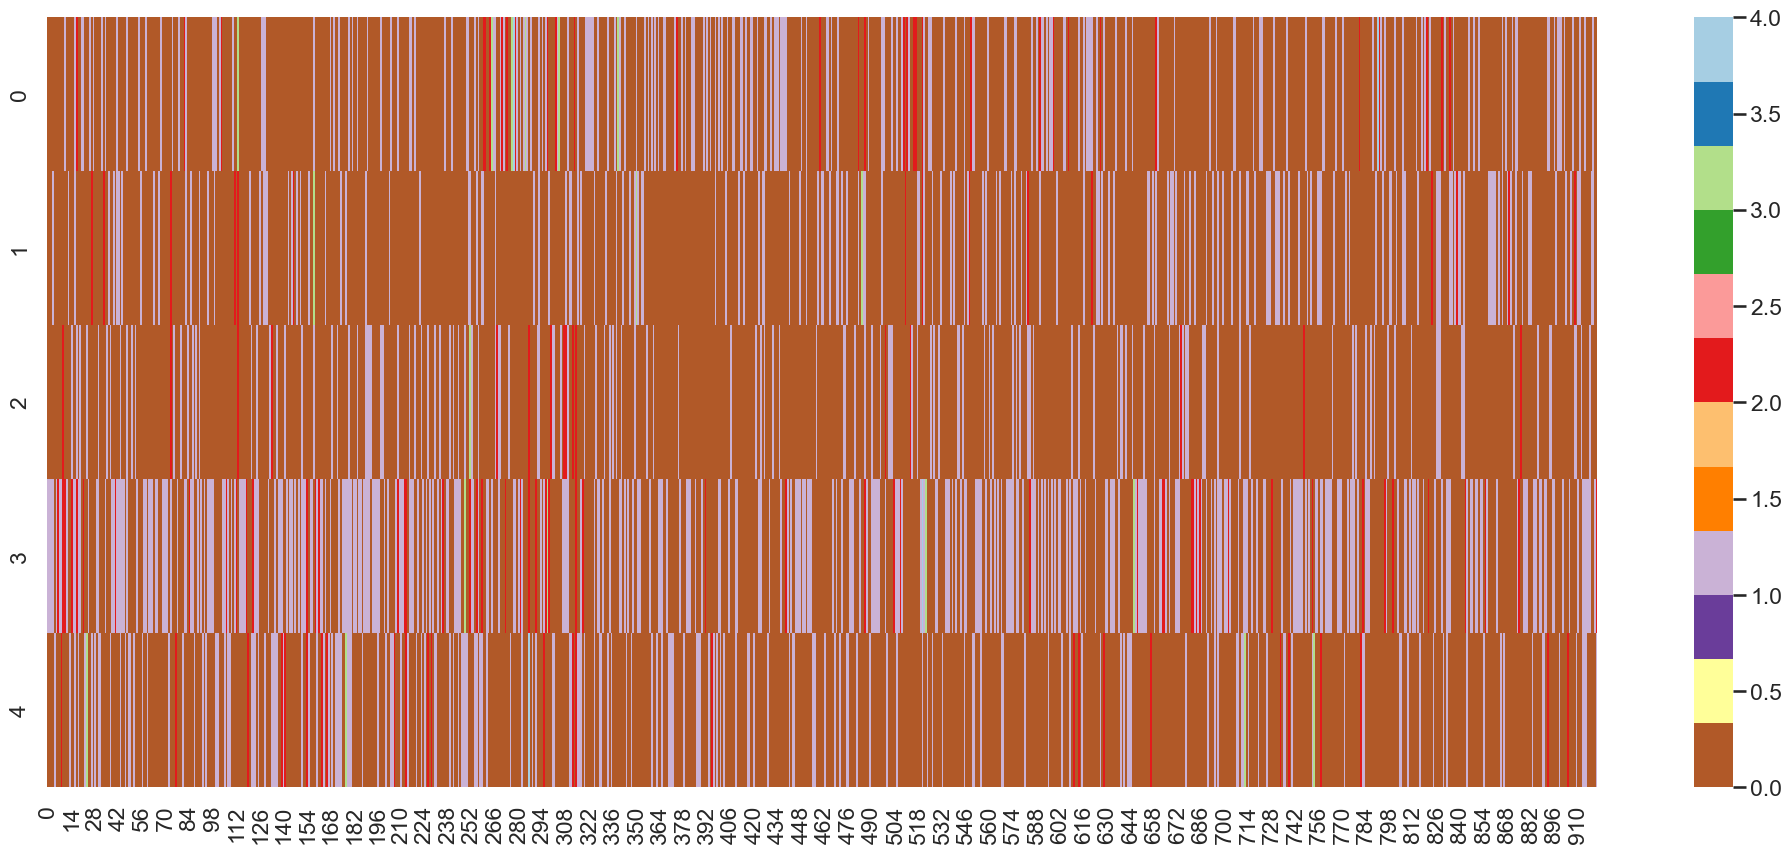

In [12]:
plt.figure(figsize=(25, 10))
rot_data = np.rot90(list(final_df_dataset["Report_as_EmotionDistribution"]))
g = sns.heatmap(
    data=rot_data,
    cmap="Paired_r"
)

The vast majority of report seems to have one-valued emotions, with littel emotion co-occurrences. This will likely make the classification problematic.

## Single Fold
### Dataset and Model Setup<a id='setup'></a>

In [13]:
# Defining model's and training specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 10
train_batch_size  = 8 # always use power of 2!
valid_batch_size  = 4
learning_rate     = 1e-05
froze_model_layer = False 

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

In [14]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset = final_df_dataset.sample(frac=train_size, random_state=seed)
test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset:  {}".format(final_df_dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset:  {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, max_length)
testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

FULL Dataset:  (922, 3)
TRAIN Dataset: (738, 3)
TEST Dataset:  (184, 3)


In [15]:
train_params = {
    'batch_size': train_batch_size,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': valid_batch_size,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader  = DataLoader(testing_set, **test_params)

In [16]:
model_tuned = BERT_arch(
    model_name=model_name, 
    n_classes=len(emotions_list), 
    freeze_BERT=False
)

model_tuned.to(device)

optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training and Evaluation<a id='train_eval'></a>
Training a model on a single split 

In [17]:
for ep in range(epochs):
    train(ep, model_tuned, training_loader, optimizer_tuned)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  0.5445330739021301
Epoch: 1, Loss:  0.238688662648201
Epoch: 2, Loss:  0.2300087958574295
Epoch: 3, Loss:  0.2416294366121292
Epoch: 4, Loss:  0.08926140516996384
Epoch: 5, Loss:  0.03578764945268631
Epoch: 6, Loss:  0.021151885390281677
Epoch: 7, Loss:  0.013408941216766834
Epoch: 8, Loss:  0.004012239631265402
Epoch: 9, Loss:  0.005464546382427216


In [18]:
outputs, targets = validation(model_tuned, testing_loader)

In [19]:
predictions_df = pd.DataFrame.from_dict(
        {"Targets":targets, "Outputs":outputs}
)

predictions_df

,Targets,Outputs
0,"[2.0, 0.0, 0.0, 0.0, 0.0]","[0.7540712356567383, 0.5, 0.5, 0.5, 0.5]"
1,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.5, 0.5, 0.5, 0.5, 0.7011001110076904]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0]","[0.5, 0.6498020887374878, 0.5, 0.5977348685264..."
3,"[0.0, 1.0, 0.0, 0.0, 0.0]","[0.6932416558265686, 0.5003474950790405, 0.571..."
4,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.5, 0.5, 0.5, 0.5, 0.7537570595741272]"
...,...,...
179,"[0.0, 1.0, 0.0, 0.0, 1.0]","[0.5, 0.778560996055603, 0.5, 0.5, 0.5]"
180,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.7478370666503906, 0.5090304017066956, 0.5, ..."
181,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.5, 0.5042165517807007, 0.5, 0.5, 0.63683092..."
182,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.6848673820495605, 0.508164644241333, 0..."


### Analysis<a id='analysis'></a>

## K-Fold Cross Validation<a id='kfold'></a>
In previous experiment, we observed a jump in perfprmance after 5 epochs. The K-Fold experimetn should allow us to understand how stable such jump is, acorss different random samples of the dataset.

## Ablation Study<a id='ablation'></a>
To test the robustness of the model, we keep one collection just for testing